In [1]:
import numpy as np
import pandas as pd

# 📈 Let's Check and Analyze 3 Keywords on Google Trends

## 🛠️ Step 1: Install and Import Required Libraries
We’ll use the `pytrends` library, an unofficial API for Google Trends.


In [2]:
!pip install pytrends

In [3]:
from pytrends.request import TrendReq
import time

## 🌐 Step 2: Connect to Google Trends API
We’ll create a connection to the API using `TrendReq`.

In [4]:
# Connect to Google Trends API
pytrends = TrendReq(hl='en-US', tz=360)

In [5]:
# Optional: Define a time frame (you can go back up to ~5 years)
# Format: 'YYYY-MM-DD YYYY-MM-DD' or 'today 5-y'
timeframe = 'today 5-y'  # last 5 years

## 🔍 Step 3: Search for Keywords

We’ll first input three keywords and then collect their search interest over time.

> ⚠️ **Important**: Google Trends may temporarily block repeated requests. If we hit a limit, we’ll wait 30–60 seconds before retrying.

In [6]:
# Taking three keywords as input from the user
keywords = []

for i in range(3):
    keyword = input(f"Enter keyword {i+1}: ")
    keywords.append(keyword.strip())

print("Your keywords are:", keywords)

Enter keyword 1: apple
Enter keyword 2: oranges
Enter keyword 3: banana
Your keywords are: ['apple', 'oranges', 'banana']


In [7]:
import random

pytrends = TrendReq(hl='en-US', tz=360)

results = {}

for kw in keywords:
    success = False
    attempts = 0
    while not success and attempts < 3:
        try:
            print(f"Trying keyword: {kw} (attempt {attempts + 1})")
            pytrends.build_payload([kw], cat=0, timeframe='today 5-y', geo='', gprop='')
            data = pytrends.interest_over_time()
            if not data.empty:
                results[kw] = data[kw]
                print(f"✅ Success for: {kw}")
            else:
                print(f"⚠️ No data returned for: {kw}")
            success = True
        except Exception as e:
            print(f"Error for {kw}: {e}")
            wait = random.uniform(30, 60)  # slower, more polite scraping
            print(f"Waiting {wait:.2f} seconds...")
            time.sleep(wait)
            attempts += 1
    if not success:
        print(f"❌ Failed to fetch: {kw} after 3 attempts")

Trying keyword: apple (attempt 1)


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


✅ Success for: apple
Trying keyword: oranges (attempt 1)


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


✅ Success for: oranges
Trying keyword: banana (attempt 1)
✅ Success for: banana


/usr/local/lib/python3.11/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


## 📊 Step 4: Create a DataFrame

In [8]:
df_trends = pd.DataFrame(results)
df_trends.index = pd.to_datetime(df_trends.index)
df_trends.head()

,apple,oranges,banana
date,,,
2020-06-28,57,49,96
2020-07-05,59,48,95
2020-07-12,59,48,100
2020-07-19,57,48,96
2020-07-26,58,47,92


# After getting the data, let's visualize it!

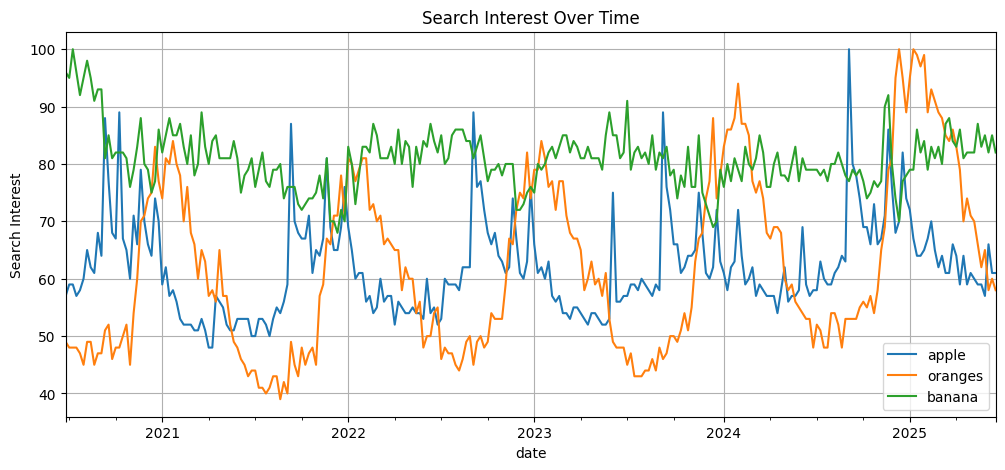

In [9]:
import matplotlib.pyplot as plt

df_trends.plot(figsize=(12,5), title='Search Interest Over Time')
plt.ylabel("Search Interest")
plt.grid(True)
plt.show()

#### Now, let's do a bit of time series!

In [10]:
!pip install prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

def analyze_keyword_trend(df_trends, keyword):
    """
    Decomposes and forecasts search interest for a given keyword.
    Expects df_trends with datetime index and keyword as a column.
    """

    if keyword not in df_trends.columns:
        print(f"❌ Keyword '{keyword}' not found in dataframe.")
        return

    print(f"\n📈 Analyzing: {keyword}")

    # Ensure datetime index
    df_trends.index = pd.to_datetime(df_trends.index)

    # 1. SEASONAL DECOMPOSITION
    decomp = seasonal_decompose(df_trends[keyword], model='additive', period=52)
    decomp.plot()
    plt.suptitle(f"Seasonal Decomposition: {keyword}", fontsize=14)
    plt.show()

    # 2. FORECASTING WITH PROPHET
    df_prophet = df_trends[[keyword]].reset_index()
    df_prophet.columns = ['ds', 'y']

    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=52, freq='W')  # 1 year
    forecast = model.predict(future)

    model.plot(forecast)
    plt.title(f"Forecast for: {keyword}")
    plt.show()

    model.plot_components(forecast)
    plt.show()

    # 3. SEASONALITY STRENGTH
    seasonality_strength = decomp.seasonal.var() / df_trends[keyword].var()
    print(f"🌀 Seasonality Strength for '{keyword}': {seasonality_strength:.2f}")


#### Analyzing time series for each keyword


📈 Analyzing: apple


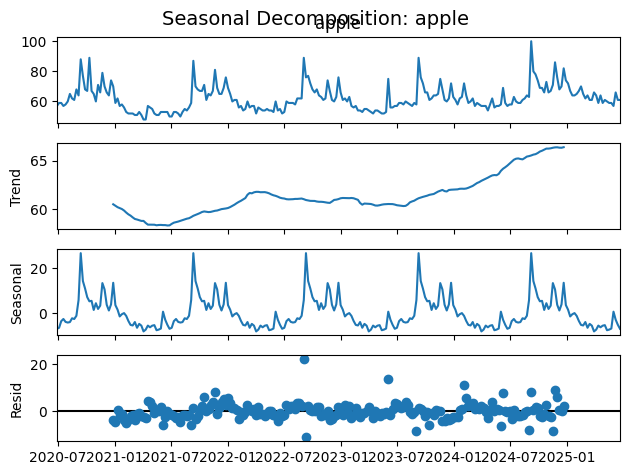

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/9feymf0r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/aue581_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38125', 'data', 'file=/tmp/tmp5ap4p44r/9feymf0r.json', 'init=/tmp/tmp5ap4p44r/aue581_d.json', 'output', 'file=/tmp/tmp5ap4p44r/prophet_modelq0xzjpmr/prophet_model-20250628133954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


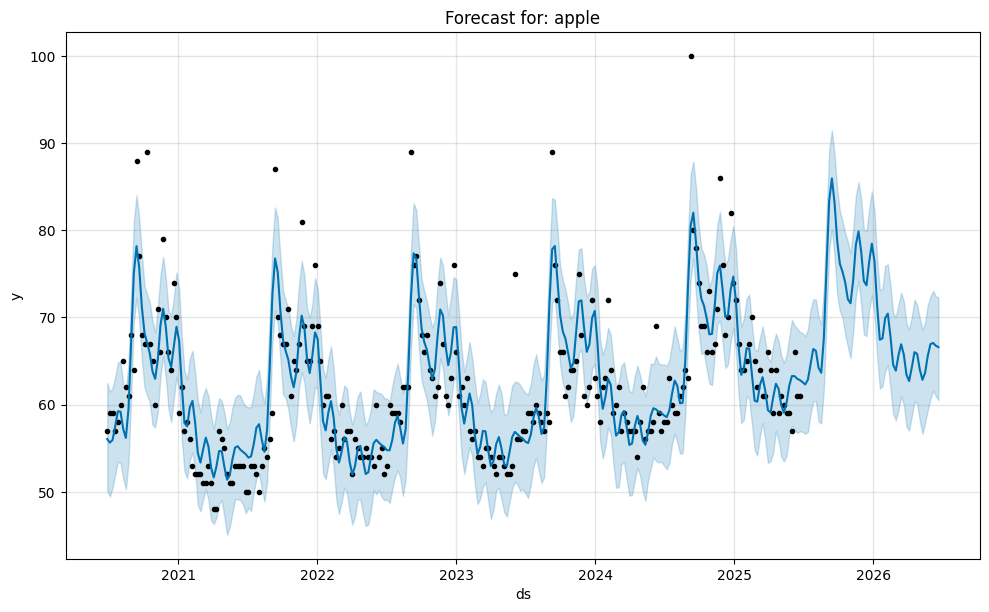

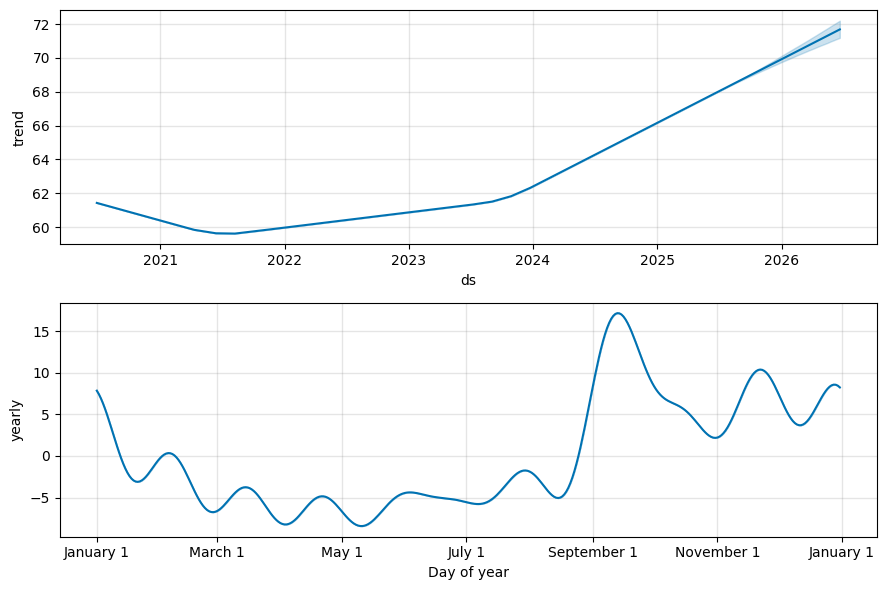

🌀 Seasonality Strength for 'apple': 0.70

📈 Analyzing: oranges


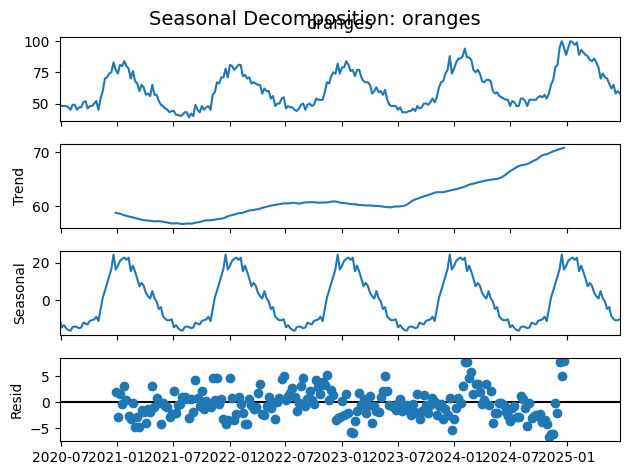

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/84m34kma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/v66f48_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51755', 'data', 'file=/tmp/tmp5ap4p44r/84m34kma.json', 'init=/tmp/tmp5ap4p44r/v66f48_r.json', 'output', 'file=/tmp/tmp5ap4p44r/prophet_modellbzmwi88/prophet_model-20250628133956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


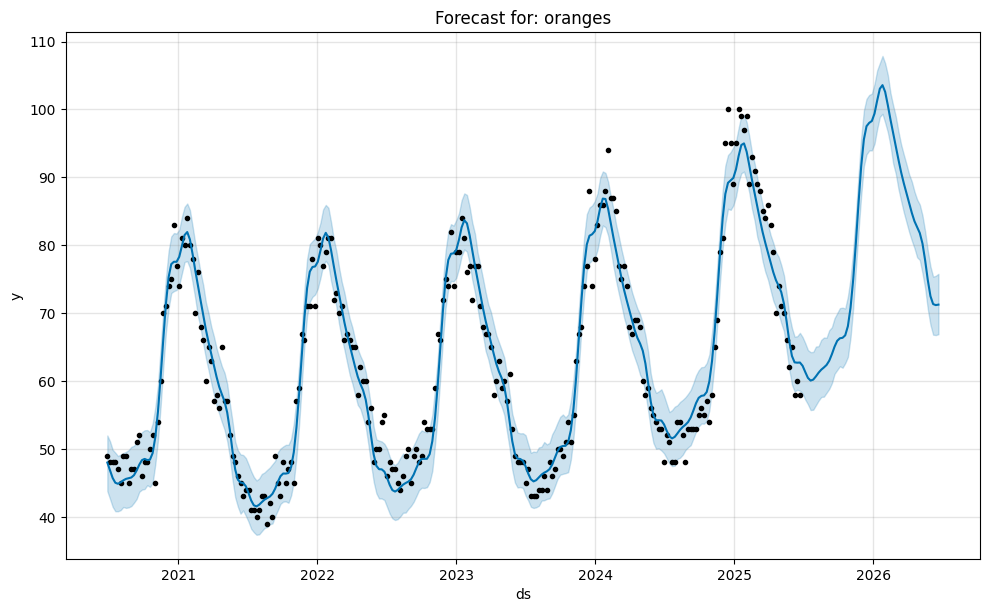

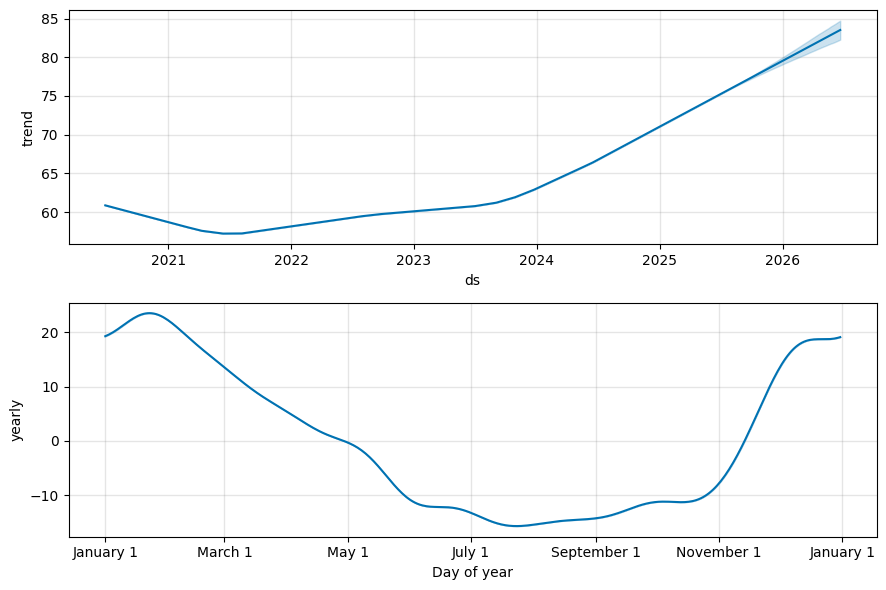

🌀 Seasonality Strength for 'oranges': 0.78

📈 Analyzing: banana


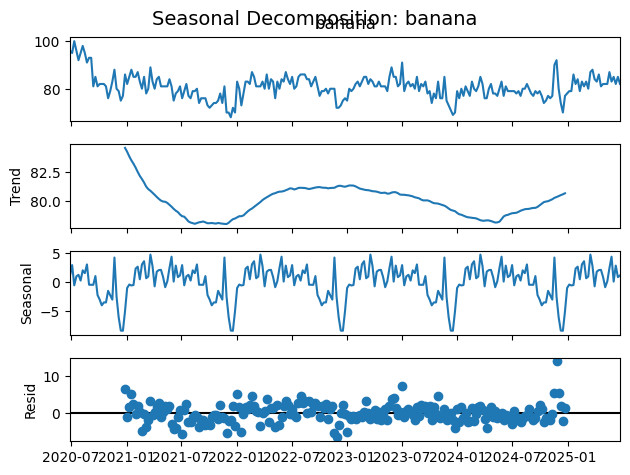

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/trh0i6zo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ap4p44r/sdtcvqg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22610', 'data', 'file=/tmp/tmp5ap4p44r/trh0i6zo.json', 'init=/tmp/tmp5ap4p44r/sdtcvqg0.json', 'output', 'file=/tmp/tmp5ap4p44r/prophet_modeluo3yulcg/prophet_model-20250628133957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


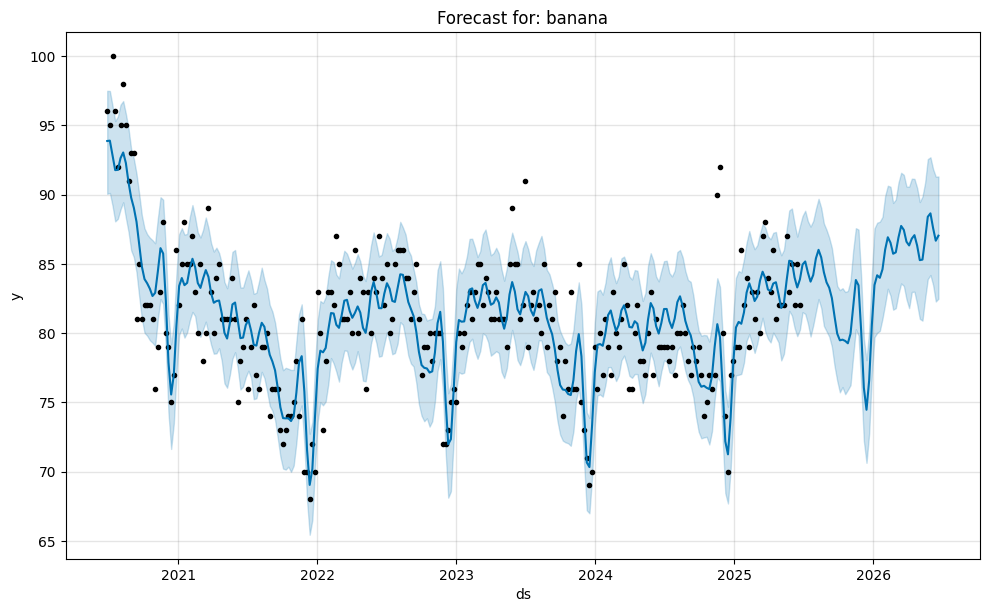

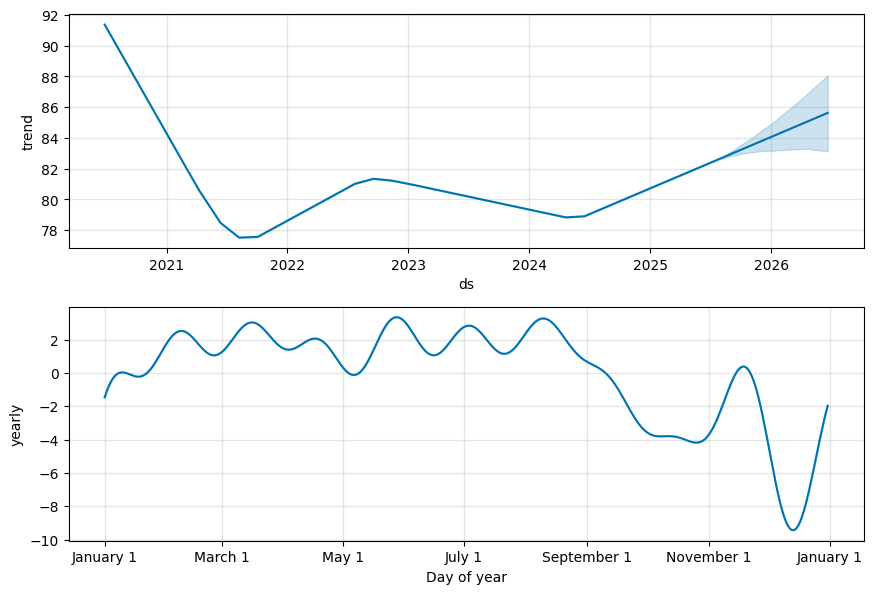

🌀 Seasonality Strength for 'banana': 0.33


In [12]:
analyze_keyword_trend(df_trends, keywords[0])
analyze_keyword_trend(df_trends, keywords[1])
analyze_keyword_trend(df_trends, keywords[2])  # if score is >0.3 = seasonal